### 0. Import packages

In [ ]:
import pandas as pd
import numpy as np
from collections import Counter
import re
import matplotlib.pyplot as plt
import seaborn as sns


### 1. Load Data

In [ ]:
# Load the Excel file
path = "sample_data/assignment/search_queries.xlsx"
df = pd.read_excel(path)
print(df.shape)
df.head()

(336862, 1)


,Search queries
0,canada lodging
1,caviar
2,condos
3,ski area
4,ski hill


### 2. Check Basic Statistics of Query Length

In [ ]:


# Basic structure
rows, cols = df.shape
non_null_counts = df.notnull().sum()

# Assume the search query column is named something reasonable; infer first column if unsure
col = df.columns[0]

# Clean non-null queries
queries = df[col].dropna().astype(str)

# Uniqueness
total_queries = len(queries)
unique_queries = queries.nunique()
duplicate_rows = total_queries - unique_queries

# Length stats
lengths = queries.str.len()

percentiles = [1,5,10,25,50,75,90,95,99,99.99]
pct_values = np.percentile(lengths, percentiles)

# Format percentile values to display as integers if they are whole numbers
formatted_percentiles = {}
for i, p in enumerate(percentiles):
    val = pct_values[i]
    if val.is_integer():
        formatted_percentiles[p] = int(val)
    else:
        formatted_percentiles[p] = float(val)

summary = {
    "rows": rows,
    "columns": cols,
    "non_null_per_column": non_null_counts.to_dict(),
    "total_non_null_queries": total_queries,
    "unique_queries": unique_queries,
    "duplicate_rows": duplicate_rows,
    "min_length": int(lengths.min()),
    "max_length": int(lengths.max()),
    "mean_length": float(lengths.mean()),
    "percentiles": formatted_percentiles
}

# Format percentile values to display as integers if they are whole numbers
formatted_percentiles = {}
for i, p in enumerate(percentiles):
    val = pct_values[i]
    if val.is_integer():
        formatted_percentiles[p] = int(val)
    else:
        formatted_percentiles[p] = float(val)

summary = {
    "rows": rows,
    "columns": cols,
    "non_null_per_column": non_null_counts.to_dict(),
    "total_non_null_queries": total_queries,
    "unique_queries": unique_queries,
    "duplicate_rows": duplicate_rows,
    "min_length": int(lengths.min()),
    "max_length": int(lengths.max()),
    "mean_length": float(lengths.mean()),
    "percentiles": formatted_percentiles
}

print("Basic Statistics Summary:")
display(summary)

Basic Statistics Summary:


{'rows': 336862,
 'columns': 1,
 'non_null_per_column': {'Search queries': 336862},
 'total_non_null_queries': 336862,
 'unique_queries': 156551,
 'duplicate_rows': 180311,
 'min_length': 1,
 'max_length': 43,
 'mean_length': 18.966790555182836,
 'percentiles': {1: 4,
  5: 6,
  10: 9,
  25: 14,
  50: 20,
  75: 24,
  90: 27,
  95: 29,
  99: 32,
  99.99: 39}}

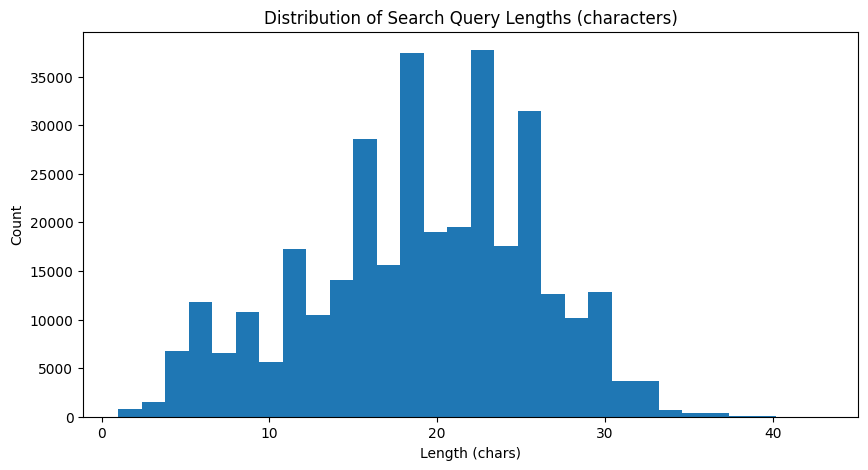

In [ ]:

# Visual Representation: Query Length Distribution
plt.figure(figsize=(10, 5))
plt.hist(lengths, bins=30)
plt.title("Distribution of Search Query Lengths (characters)")
plt.xlabel("Length (chars)")
plt.ylabel("Count")
plt.show()

### Basic Statistics based on Query Length

- **Results**
  - Rows: 336,862, Columns: 1
  - Non-null: 100%
  - Unique queries: 156,551
  - Duplicate rows: 180,311
  - Length (chars): min 1, max 43, mean ~19
  - Median length: 20
  - 90th percentile: 27, 99th: 32, 99.99th: 39

- **Takeaway**
  - This Dataset looks somewhat clean +  large size with a strong repeat-rate → this makes it good for clustering or for prioritizing high-volume intents.

### 3 Head–Tail Distribution
Top frequently searched queries by frequency

In [ ]:

# 3) Frequency / Head–Tail Analysis
freq = queries.value_counts().sort_values(ascending=False)

head_tail = {
    "top_10_pct_traffic": float(freq.head(10).sum() / total_queries),
    "top_100_pct_traffic": float(freq.head(100).sum() / total_queries),
    "top_1000_pct_traffic": float(freq.head(1000).sum() / total_queries),
}

print("\n=== Head–Tail Summary ===")
display(head_tail)


=== Head–Tail Summary ===


{'top_10_pct_traffic': 0.0463928849202344,
 'top_100_pct_traffic': 0.10135307633392902,
 'top_1000_pct_traffic': 0.17487576515012082}

,query,count
0,airbnb,5684
1,properties for rent,2273
2,places to stay,1507
3,condos,1074
4,house,1019
5,villas,1008
6,air b and b,860
7,resorts,771
8,apartment,747
9,cottage,685


- **Results**
  - Top 10 queries → ~4.6% of traffic
  - Top 100 queries → ~10.1%
  - Top 1,000 queries → ~17.5%

  Do we have a 80-20 rule scenario? Checking this below:

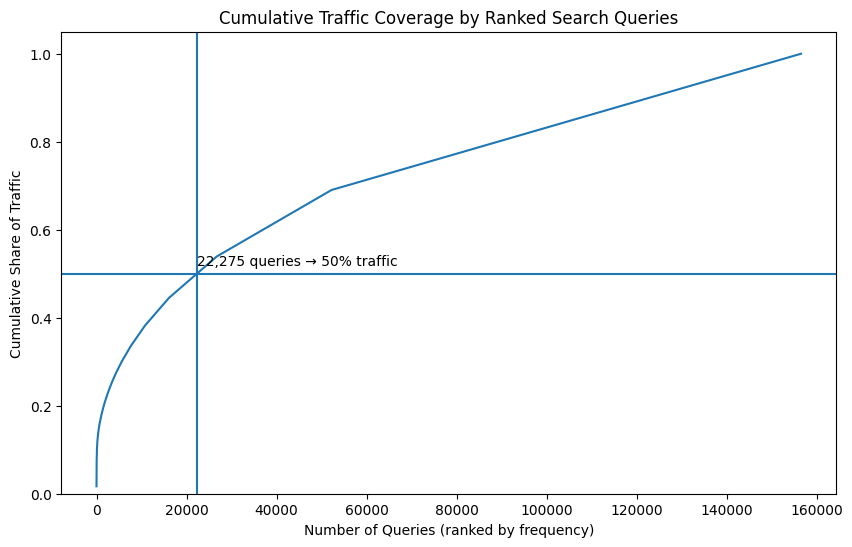

22275

In [ ]:

# Cumulative coverage
cum_counts = freq.cumsum()
total = freq.sum()
cum_pct = cum_counts / total

# How many queries explain 50% of traffic
num_queries_50pct = int((cum_pct <= 0.5).sum() + 1)

# Plot cumulative coverage curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cum_pct) + 1), cum_pct.values)
plt.axhline(0.5)
plt.axvline(num_queries_50pct)
plt.text(num_queries_50pct, 0.52, f"{num_queries_50pct:,} queries → 50% traffic", ha="left")

plt.title("Cumulative Traffic Coverage by Ranked Search Queries")
plt.xlabel("Number of Queries (ranked by frequency)")
plt.ylabel("Cumulative Share of Traffic")
plt.ylim(0, 1.05)
plt.show()

num_queries_50pct


### Results: Query Demand Is Highly Long-Tailed
(Prior to removing stop words)

- Around 22K unique queries (~14% of 156K unique queries) are required to explain just 50% of traffic
  - This clearly indicates a long-tail problem
  - At the same time the distribution does not support an 80-20 pareto rule because:
    - If this were Pareto:
      - ~20% of queries would explain ~80% of traffic
    - Instead:
      - ~14% explain only 50%
      - Even the top 1,000 queries explained just ~17.5%

- This means:
  - Simple Rule-based personalization won’t work well
  - Semantic generalization or intent clustering method is required as demand is fragmented across tens of thousands of queries
  - Why confidence thresholds + fallbacks are necessary


In [ ]:
# Top 10 most frequent queries
top_10_queries = queries.value_counts().head(10).reset_index()
top_10_queries.columns = ["query", "count"]

top_10_queries

,query,count
0,airbnb,5684
1,properties for rent,2273
2,places to stay,1507
3,condos,1074
4,house,1019
5,villas,1008
6,air b and b,860
7,resorts,771
8,apartment,747
9,cottage,685


### Results:

**How to interpret this**

- **These are category-only / inventory-type queries**
    - No destinations
    - No dates
    - No modifiers (cheap, family, luxury)
  - **This means:**
    - The highest-volume queries are early-funnel, exploratory searches.

- **Strong brand + synonym effects**
  - airbnb vs air b and b
  - house, condos, apartment, villas, cottage
    - Users are searching for types of accommodation, not trips yet
    - Normalization and semantic grouping will matter a lot for analyzing

- **Why this matters for landing pages**
  - **If a user searches:**
    - “airbnb” or "air b and b"
  - **Routing them to:**
    - a destination-specific page would be wrong
    - a luxury/family persona would be risky
    - a category discovery page (“Explore vacation rentals”) is correct
  - **So these top queries directly justify:**
    - Category-based fallback experiences
    - Not over-personalizing the highest-volume traffic.

**Key Insight 1**

Interestingly, our top 10 queries are all category-level terms like ‘airbnb’, ‘condos’, and ‘places to stay’, which tells us the highest-volume traffic is exploratory. That strongly influenced our fallback design toward category discovery pages rather than aggressive intent personalization


- **Next Steps for these high level exploratory queries:**
  - Group these top queries into semantic families
  - Show how much traffic is brand-led vs generic
  - Or map top queries → recommended landing templates

### 4. Single/Multi Token Term Analysis (Brute force Method)

In [ ]:
STOPWORDS = set(["the","and","for","a","to","in","of","is","on","with"])
_word_re = re.compile(r"[a-zA-Z]+")

def tokenize(text):
    toks = _word_re.findall(str(text).lower())
    return [t for t in toks if t not in STOPWORDS]

tokens = queries.apply(tokenize)

# Build single-token dataframe
single_df = pd.DataFrame({
    "query": queries,
    "tokens": tokens,
    "token_count": tokens.apply(len)
})

single_df = single_df[single_df["token_count"] == 1].copy()
single_df["token"] = single_df["tokens"].apply(lambda x: x[0])

# --- Destination vocabulary (example / extensible) ---
DESTINATION_TERMS = {
    "paris","florida","hawaii","orlando","vegas","miami","california",
    "costa","mexico","utah","colorado","tahoe","yosemite","yellowstone",
    "london","rome","italy","spain","france","greece","cancun","bahamas"
}

STAY_TERMS = {
    "hotel","hotels","resort","resorts","lodging","airbnb",
    "rental","rentals","hostel","motels","bnb","inn",
    "villa","villas","condo","condos","apartment","apartments","cottage","house"
}

EXPERIENCE_TERMS = {
    "beach","ski","camping","cruise","vacation","honeymoon",
    "luxury","budget","family","romantic","adventure"
}

def classify_token(tok):
    if tok in DESTINATION_TERMS:
        return "destination"
    if tok in STAY_TERMS:
        return "stay"
    if tok in EXPERIENCE_TERMS:
        return "experience"
    return "misc"

single_df["bucket"] = single_df["token"].apply(classify_token)

bucket_counts = (
    single_df["bucket"]
    .value_counts()
    .to_frame("count")
)
bucket_counts["pct_of_single_token"] = bucket_counts["count"] / len(single_df)
bucket_counts["pct_of_all_queries"] = bucket_counts["count"] / len(queries)


bucket_counts


,count,pct_of_single_token,pct_of_all_queries
bucket,,,
misc,22622,0.626475,0.067155
stay,12606,0.349100,0.037422
destination,595,0.016477,0.001766
experience,287,0.007948,0.000852


,confidence_score
count,336862.000000
mean,0.576597
std,0.250408
min,0.000000
10%,0.000000
25%,0.450000
50%,0.628000
75%,0.753000
90%,0.860000
max,0.900000


In [ ]:
# 4) Sample examples per bucket
examples = (
    single_df.groupby("bucket")
    .apply(lambda x: x.sample(min(5, len(x)), random_state=42)["query"].tolist())
)
examples


/tmp/ipython-input-2815100333.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(min(5, len(x)), random_state=42)["query"].tolist())


,0
bucket,
destination,"[hawaii, hawaii, colorado, hawaii, hawaii]"
experience,"[beach, camping, camping, ski, camping]"
misc,"[events, bayside, reviews, vacations, manualoha]"
stay,"[lodging, airbnb, resorts, condos, airbnb]"


### Results and Takeaways from Token Analysis

- **Share of single-token queries across all queries**
  - Single-token queries account for ~10.7% of all traffic (i.e. 336,862 total queries) after cleaning (lowercasing, removing punctuation and filler words). In other words roughly ~11% of traffic is inherently ambiguous and risky to personalize.

  - Further breakdown of these:
    - Bucket: Misc, % of all queries: 6.7%
    - Bucket: Stay, % of all queries: 3.7%
    - Bucket: Destination, % of all queries: 0.18%
    - Bucket: Experience, % of all queries: 0.09%


- **Breakdown of share within single-token queries**
  - Bucket: Misc, % of single-token: 62.6%
  - Bucket: Stay, % of single-token: 34.9%
  - Bucket: Destination, % of single-token: 1.6%
  - Bucket: Experience, % of single-token: 0.8%


  **Stays are popular single token searches**
   Common ambiguous single-token queries are NOT destinations usually Misc or stays
  - They’re mostly:
    - Stay (“airbnb”)
    - Misc concepts like time or other noisy attributes (“vacations”,“february”)


- **Action items**
  - **What not to do**
    - Don’t route single-token traffic to destination pages by default

  - **What to do**
    - Stay tokens → Stay discovery pages
    - Experience tokens → experience hubs
    - Destination tokens → destination hubs
    - Misc tokens → safe generic homepage or guided chooser


  

In [ ]:

# 3) Confidence score heuristic - How confident are we that we understand this user’s intent?
# ---------------------------
# Intuition:
# - More tokens → higher confidence
# - Longer query → higher confidence
# - Single-token → penalty

# Hypothetical formula using above intution
# confidence =
#   + token richness
#   + length richness
#   – ambiguity penalty
# Score is clipped between 0 and ~0.9.

def confidence_score(row):
    score = 0.0

    # token contribution
    score += min(row["token_count"] / 4, 1.0) * 0.5

    # length contribution
    score += min(row["char_len"] / 30, 1.0) * 0.4

    # ambiguity penalty
    if row["token_count"] == 1:
        score -= 0.3

    return round(max(score, 0), 3)

confidence_df = pd.DataFrame({
    "query": queries,
    "token_count": tokens.apply(len),
    "char_len": lengths
})

confidence_df["confidence_score"] = confidence_df.apply(confidence_score, axis=1)

confidence_distribution = confidence_df["confidence_score"].describe(
    percentiles=[0.1,0.25,0.5,0.75,0.9]
)

confidence_distribution

,confidence_score
count,336862.000000
mean,0.576597
std,0.250408
min,0.000000
10%,0.000000
25%,0.450000
50%,0.628000
75%,0.753000
90%,0.860000
max,0.900000


### Results on Intent Confidence Distribution

What this shows

Distribution of an intent confidence score across 336,862 search queries — a proxy for how well we understand user intent based on query length, meaningful tokens, and ambiguity (think risk spectrum, not model accuracy).

- **~25% of traffic is low-confidence (high risk)**
  - Confidence score ≤ 0.45
  - Typically single-token or vague queries (category, time, generic terms)
  - Recommendation: route to generic or guided experiences only

- **~50% of traffic is medium-confidence (safe to personalize coarsely)**
  - Confidence score ~ 0.45–0.75
  - Queries express destination + basic intent
  - Recommendation: apply coarse personas (e.g., beach, family, ski)

- **~25% of traffic is high-confidence (strong personalization opportunity)**
  - Confidence score ≥ 0.75
  - Highly specific, intent-rich queries
  - Recommendation: aggressive intent-aware landing experiences

### 5. Word Frequency Analysis (Or Unigrams)


Top 20 Most Common Words:
airbnb: 31642
beach: 20457
resort: 19415
resorts: 18623
hotels: 15144
vacation: 10872
florida: 9833
rent: 9192
lodging: 9017
b: 8140
ski: 7500
family: 7383
house: 7338
island: 7192
rentals: 6852
places: 6556
park: 6274
lake: 6081
bed: 6070
lodge: 5611


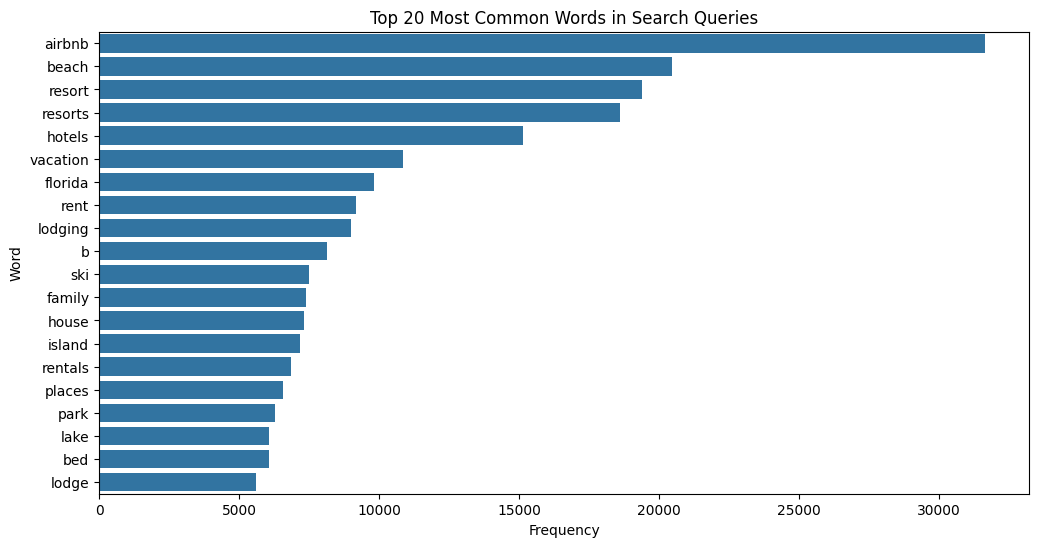

In [ ]:
# Combine all queries into a single string and tokenize
all_words = ' '.join(queries).lower()
words = re.findall(r'\b\w+\b', all_words) # Extract words, excluding punctuation

# Remove common stopwords (optional, but good for meaningful insights)
stopwords = set(['the', 'and', 'for', 'a', 'to', 'in', 'of', 'is', 'on', 'with'])
filtered_words = [word for word in words if word not in stopwords]

# Get word frequencies
word_counts = Counter(filtered_words)

# Display top N most common words
print("\nTop 20 Most Common Words:")
for word, count in word_counts.most_common(20):
    print(f"{word}: {count}")

# Visualize top words
top_words_df = pd.DataFrame(word_counts.most_common(20), columns=['Word', 'Count'])
plt.figure(figsize=(12, 6))
sns.barplot(x='Count', y='Word', data=top_words_df)
plt.title('Top 20 Most Common Words in Search Queries')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.show()

### 6. N-gram Analysis for N>1 (e.g., Bigrams)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.



Top 20 Most Common Bigrams:
for rent: 6449
bed and: 5683
and breakfast: 5200
places to: 3800
all inclusive: 3328
to stay: 3214
costa rica: 2546
properties for: 2276
b &: 2196
national park: 2121
& b: 2041
beach resort: 2021
b and: 1962
family resorts: 1938
air b: 1937
key west: 1936
and b: 1913
to visit: 1729
myrtle beach: 1649
ski resort: 1617


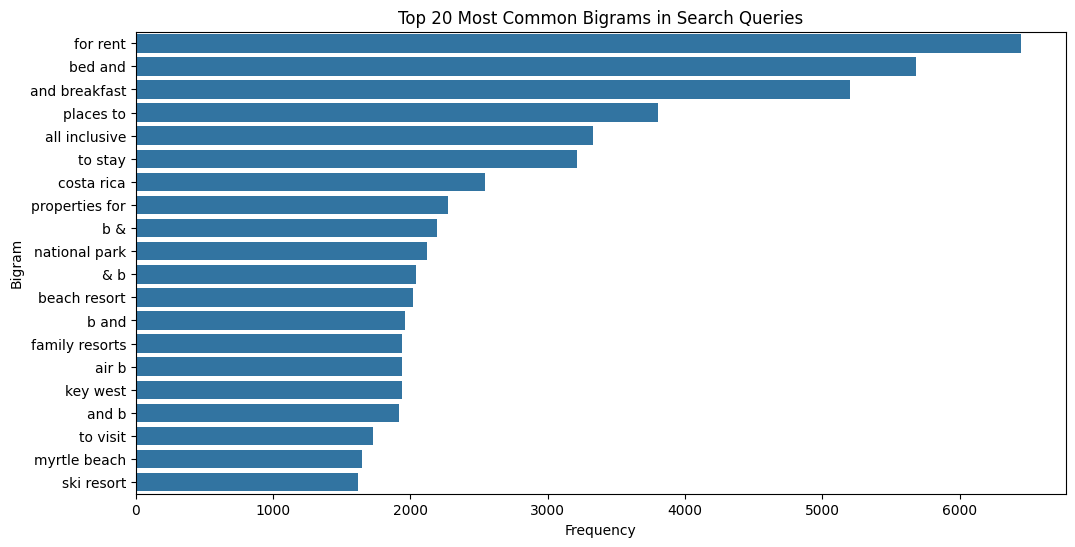

In [ ]:
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt') # Download the punkt tokenizer for word_tokenize
nltk.download('punkt_tab') # Download the specific punkt_tab resource as suggested by the error

# Function to get n-grams
def get_ngrams(text, n):
    token = word_tokenize(text.lower())
    n_grams = ngrams(token, n)
    return [' '.join(grams) for grams in n_grams]

# Get bigrams (sequences of 2 words)
all_bigrams = []
for query in queries:
    all_bigrams.extend(get_ngrams(query, 2))

bigram_counts = Counter(all_bigrams)

print("\nTop 20 Most Common Bigrams:")
for bigram, count in bigram_counts.most_common(20):
    print(f"{bigram}: {count}")

# Visualize top bigrams
top_bigrams_df = pd.DataFrame(bigram_counts.most_common(20), columns=['Bigram', 'Count'])
plt.figure(figsize=(12, 6))
sns.barplot(x='Count', y='Bigram', data=top_bigrams_df)
plt.title('Top 20 Most Common Bigrams in Search Queries')
plt.xlabel('Frequency')
plt.ylabel('Bigram')
plt.show()


Top 20 Most Common Trigrams:
bed and breakfast: 5200
properties for rent: 2275
b & b: 2028
places to stay: 1997
b and b: 1907
air b and: 1842
homes for rent: 1226
houses for rent: 1131
all inclusive resorts: 1126
places to visit: 963
ski in ski: 647
in ski out: 647
condos for rent: 625
turks and caicos: 611
place to stay: 564
panama city beach: 516
bed and breakfasts: 483
anna maria island: 471
things to do: 440
cabo san lucas: 398


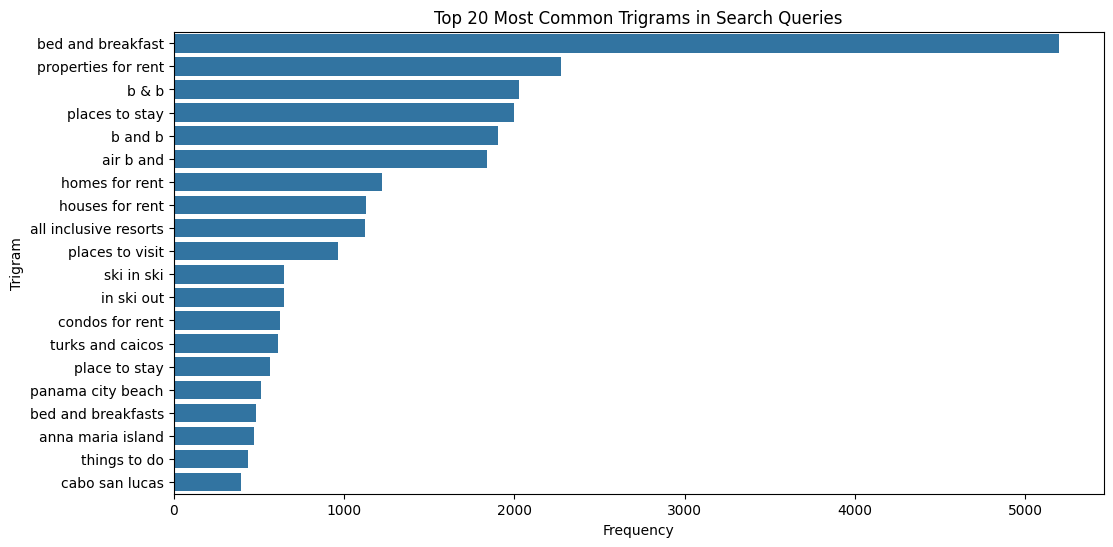

In [ ]:

# Get trigrams (sequences of 3 words)
all_trigrams = []

for query in queries:
    all_trigrams.extend(get_ngrams(query, 3))

trigram_counts = Counter(all_trigrams)

print("\nTop 20 Most Common Trigrams:")
for trigram, count in trigram_counts.most_common(20):
    print(f"{trigram}: {count}")

# Visualize top trigrams
top_trigrams_df = pd.DataFrame(
    trigram_counts.most_common(20),
    columns=['Trigram', 'Count']
)

plt.figure(figsize=(12, 6))
sns.barplot(x='Count', y='Trigram', data=top_trigrams_df)
plt.title('Top 20 Most Common Trigrams in Search Queries')
plt.xlabel('Frequency')
plt.ylabel('Trigram')
plt.show()




In [ ]:


tokens = queries.apply(tokenize)
word_counts = tokens.apply(len)

# Compute median ± 1 std (WORD count)
median_wc = int(word_counts.median())
std_wc = int(round(word_counts.std()))

lower = max(1, median_wc - std_wc)
upper = median_wc + std_wc

print(f"Typical word-count range: [{lower}, {upper}]")

# Select typical-length queries
typical_queries = queries[(word_counts >= lower) & (word_counts <= upper)]
typical_tokens = tokens[(word_counts >= lower) & (word_counts <= upper)]

print(f"Queries in typical range: {len(typical_queries):,}")

# Treat full queries as long 'N-grams'
# Join tokens back into cleaned phrases
typical_phrases = typical_tokens.apply(lambda t: " ".join(t))

phrase_counts = Counter(typical_phrases)

# Top representative phrases
top_phrases = phrase_counts.most_common(20)

print("\nTop representative intent phrases (typical-length queries):")
for phrase, count in top_phrases:
    print(f"{phrase}: {count}")


Typical word-count range: [2, 4]
Queries in typical range: 287,994

Top representative intent phrases (typical-length queries):
properties rent: 2356
places stay: 1510
air b b: 947
homes rent: 563
place stay: 530
bed breakfast: 528
vacation homes: 490
condos rent: 460
vacation rentals: 426
house rent: 424
bedroom apartments: 334
all inclusive resorts: 262
spring breaks: 246
lift tickets: 237
ski ski out: 226
guest house: 215
airbnb st: 215
family vacation: 214
real estate: 206
pet friendly airbnb: 205


### Results:

These are examples of full queries whose word length falls within the typical range (median ± 1 std) to surface representative, well-formed intent phrases that best describe how users naturally express travel intent. Note: median is 3 after removing stop words and 1 std dev is 1.02 words

- complete intents
- copy-ready for Ad text
- persona-defining
- landing-page-friendly

### Action Item

This brute force NLP analysis gives us an understandng of:
- Canonical intent expressions
- The exact language users use for longer queries (2-5 token).
- Natural candidates for:
  - hero headlines
  - landing page variants
  - cluster labels

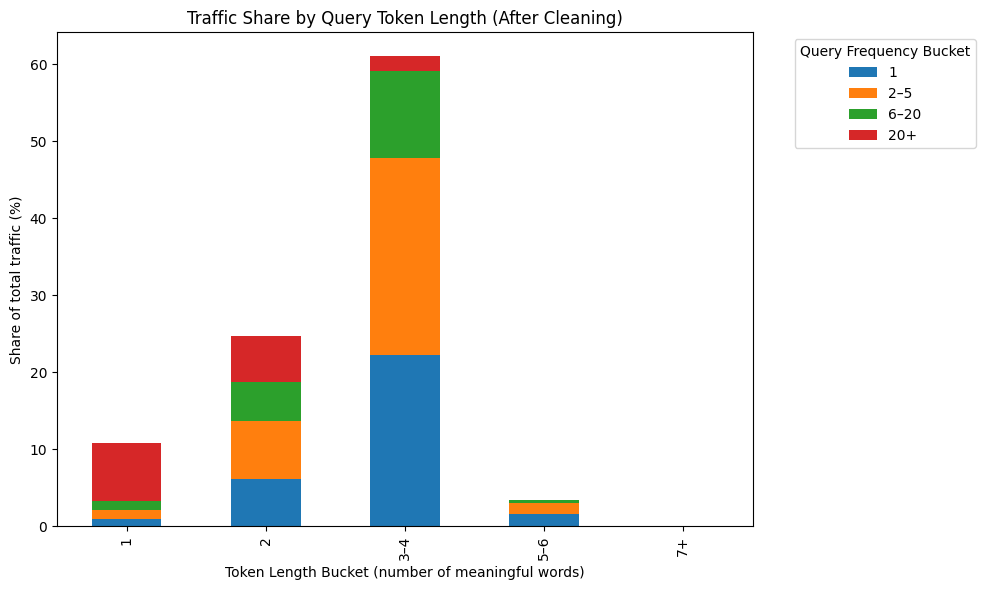

In [ ]:
tokens = queries.apply(tokenize)
token_len = tokens.apply(len)

# ---------------------------
# Frequency per unique query
# ---------------------------
freq_map = queries.value_counts()
query_freq = queries.map(freq_map)

# ---------------------------
# Token-length buckets (after cleaning)
# ---------------------------
token_len_bins = pd.cut(
    token_len,
    bins=[0, 1, 2, 4, 6, 10**9],
    labels=["1", "2", "3–4", "5–6", "7+"]
)

# Frequency buckets
freq_bins = pd.cut(
    query_freq,
    bins=[0, 1, 5, 20, 10**9],
    labels=["1", "2–5", "6–20", "20+"]
)

# ---------------------------
# Crosstab (traffic share)
# ---------------------------
ct_tokens = pd.crosstab(token_len_bins, freq_bins, normalize="all")

# ---------------------------
# OPTION A (Token-based): Stacked bar
# ---------------------------
(ct_tokens * 100).plot(
    kind="bar",
    stacked=True,
    figsize=(10, 6)
)

plt.title("Traffic Share by Query Token Length (After Cleaning)")
plt.xlabel("Token Length Bucket (number of meaningful words)")
plt.ylabel("Share of total traffic (%)")
plt.legend(
    title="Query Frequency Bucket",
    bbox_to_anchor=(1.05, 1),
    loc="upper left"
)
plt.tight_layout()
plt.show()



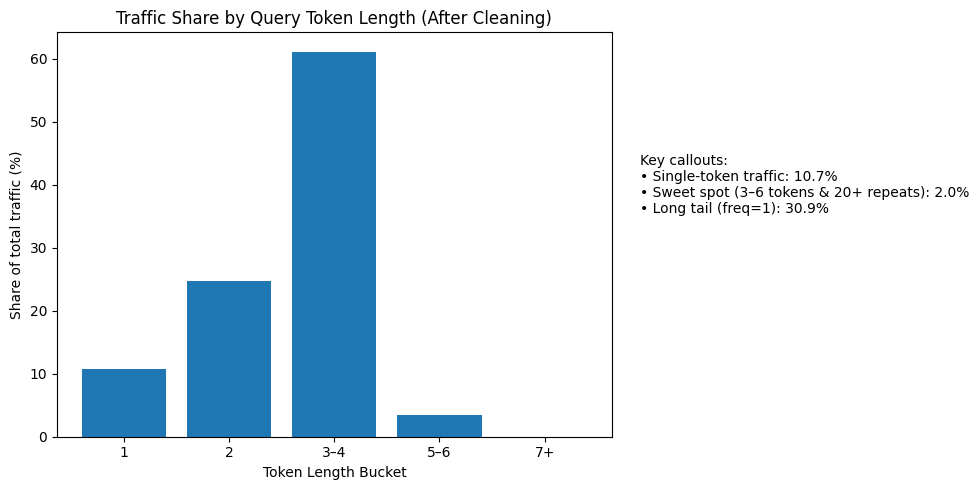

Search queries,1,2–5,6–20,20+
Search queries,,,,
1,0.0093,0.0116,0.0116,0.0751
2,0.0615,0.0755,0.0510,0.0591
3–4,0.2224,0.2555,0.1138,0.0194
5–6,0.0158,0.0139,0.0042,0.0001
7+,0.0000,0.0000,0.0000,0.0000


In [ ]:

# ---------------------------
# OPTION C (Token-based): Simple bar + callouts
# ---------------------------
total_by_token_len = ct_tokens.sum(axis=1) * 100

fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(total_by_token_len.index, total_by_token_len.values)
ax.set_title("Traffic Share by Query Token Length (After Cleaning)")
ax.set_xlabel("Token Length Bucket")
ax.set_ylabel("Share of total traffic (%)")

# Key callouts
single_token_share = float((token_len == 1).mean() * 100)
mid_token_high_freq = float(
    (ct_tokens.loc["3–4", "20+"] + ct_tokens.loc["5–6", "20+"]) * 100
)

callout_text = (
    f"Key callouts:\n"
    f"• Single-token traffic: {single_token_share:.1f}%\n"
    f"• Sweet spot (3–6 tokens & 20+ repeats): {mid_token_high_freq:.1f}%\n"
    f"• Long tail (freq=1): {float(ct_tokens['1'].sum()*100):.1f}%"
)

ax.text(1.05, 0.7, callout_text, transform=ax.transAxes, fontsize=10, va="top")

plt.tight_layout()
plt.show()

ct_tokens.round(4)

Slide 1 — Traffic by Intent Richness (Token Length × Repeat Frequency)
What this chart shows

Distribution of all traffic by number of meaningful words in the query (after cleaning)

Bars are stacked by how often the same query repeats (1, 2–5, 6–20, 20+)

This answers: “How much usable intent do users provide, and how repeatable is it?”

How to read this chart

X-axis: Query intent richness (number of meaningful words)

Bar height: Share of total traffic

Color stack: Repeat frequency of the same query

Higher repeat = more stable, reusable intent

Key insights

3–4 word queries dominate traffic (~61%)

This is the center of mass of user intent

Queries are both interpretable and common

Single-token queries (~11%) remain a meaningful risk bucket

High repeat exists, but intent is ambiguous

High-repeat traffic exists across all token lengths

Especially strong in:

1-token (e.g., “airbnb”)

3–6 token queries (clearer intent)

Long tail persists

~31% of traffic comes from queries seen only once

Action items

Prioritize personalization for 3–6 token queries

Best balance of intent clarity + repeatability

Treat single-token queries as high-risk

Route to category or guided discovery pages

Avoid query-level rules

Long tail size requires intent generalization (clustering/embeddings)

📊 Slide 2 — Where the Opportunity Is (Token Length View + Key Callouts)
What this chart shows

Simplified view of traffic share by token length

Augmented with key callouts to guide decisions

How to read this chart

Taller bars = where most traffic lives

Callouts highlight:

Ambiguous traffic

High-confidence “sweet spot”

Long-tail constraint

Key insights

~61% of traffic has 3–4 meaningful words

Ideal for intent-aware routing

~10.7% of traffic is single-token

Structurally ambiguous; unsafe to over-personalize

Only ~2% of traffic is both mid-token (3–6) and highly repeatable (20+)

Small but extremely high-confidence, high-ROI segment

~31% of traffic is unique (freq = 1)

Reinforces need for semantic generalization

Action items

Adopt a tiered routing strategy

1 token → generic / guided experience

2–4 tokens → coarse intent-based landing

5–6 tokens + high confidence → aggressive personalization

Use confidence thresholds

Avoid forcing intent on ambiguous traffic

Measure success by confidence band

Expect different lift profiles by segment

Optional executive closing line (if you want one)

“Most of our traffic already expresses usable intent — but not all of it safely. Token length gives us a simple, explainable way to personalize where it’s effective and fall back where it’s risky.”


Overlay:


/tmp/ipython-input-3053885834.py:56: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


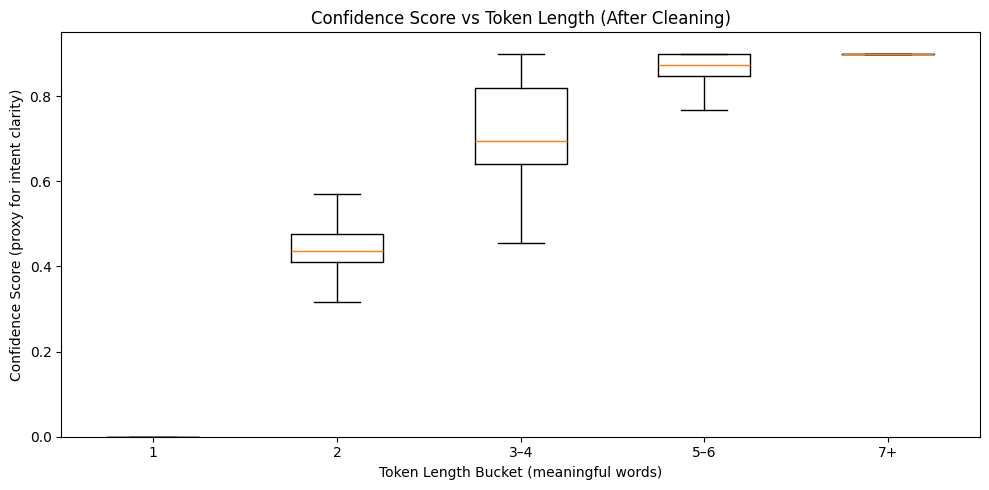

/tmp/ipython-input-3053885834.py:73: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  plot_df.groupby("token_bucket")["confidence"]


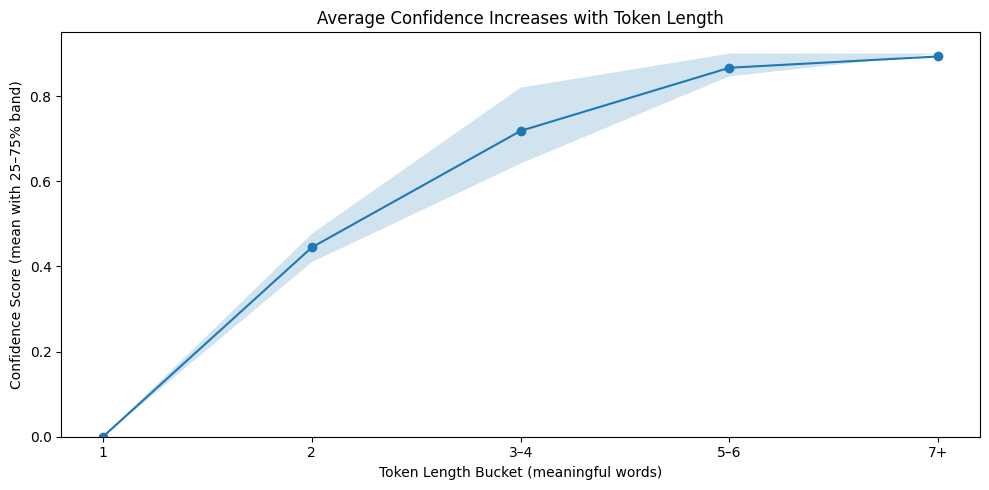

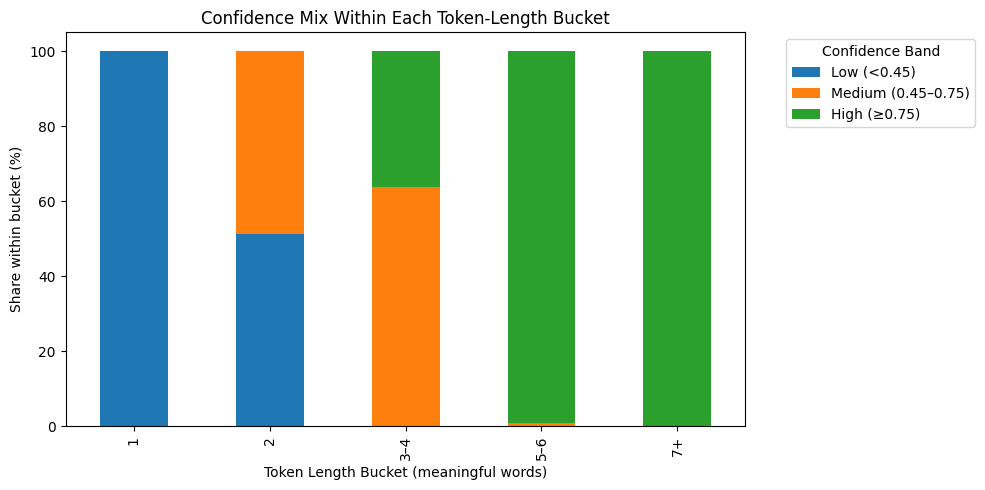

Summary (by token bucket):
               mean    p25    p75       n
token_bucket                             
1             0.000  0.000  0.000   36110
2             0.445  0.410  0.477   82919
3–4           0.719  0.642  0.820  205075
5–6           0.867  0.847  0.900   11428
7+            0.893  0.900  0.900      14

Confidence mix within bucket (%):
conf_band     Low (<0.45)  Medium (0.45–0.75)  High (≥0.75)
token_bucket                                               
1                   100.0                 0.0           0.0
2                    51.1                48.9           0.0
3–4                   0.0                63.8          36.2
5–6                   0.0                 0.8          99.2
7+                    0.0                 0.0         100.0


In [ ]:


# ===========================
# 1) Tokenize (after cleaning)
# ===========================
STOPWORDS = set(["the","and","for","a","to","in","of","is","on","with"])
_word_re = re.compile(r"[a-zA-Z]+")

def tokenize(text: str):
    toks = _word_re.findall(str(text).lower())
    return [t for t in toks if t not in STOPWORDS]

tokens = queries.apply(tokenize)
token_count = tokens.apply(len)
char_len = queries.str.len()

# ===========================
# 2) Confidence score (same intuition as before)
#    - more tokens → higher confidence
#    - longer query → higher confidence
#    - single-token → penalty
#    Score is clipped to [0, 0.9] for interpretability
# ===========================
def confidence_score(tc, cl):
    score = 0.0
    score += min(tc / 4, 1.0) * 0.5         # token richness
    score += min(cl / 30, 1.0) * 0.4        # length richness
    if tc == 1:
        score -= 0.3                        # ambiguity penalty
    return max(0.0, min(0.9, score))

conf = [confidence_score(tc, cl) for tc, cl in zip(token_count, char_len)]
conf = pd.Series(conf)

# ===========================
# 3) Bucket token length (exec-friendly)
# ===========================
token_bins = pd.cut(
    token_count,
    bins=[0, 1, 2, 4, 6, 10**9],
    labels=["1", "2", "3–4", "5–6", "7+"]
)

plot_df = pd.DataFrame({
    "token_bucket": token_bins,
    "confidence": conf
}).dropna()

bucket_order = ["1", "2", "3–4", "5–6", "7+"]

# ===========================
# CHART A (Exec-friendly): Boxplot of confidence by token bucket
# WHY: Shows "risk spectrum" + variability clearly.
# ===========================
data_for_box = [plot_df.loc[plot_df["token_bucket"] == b, "confidence"].values for b in bucket_order]

plt.figure(figsize=(10, 5))
plt.boxplot(
    data_for_box,
    labels=bucket_order,
    showfliers=False
)
plt.title("Confidence Score vs Token Length (After Cleaning)")
plt.xlabel("Token Length Bucket (meaningful words)")
plt.ylabel("Confidence Score (proxy for intent clarity)")
plt.ylim(0, 0.95)
plt.tight_layout()
plt.show()

# ===========================
# CHART B (Even simpler): Mean confidence with 25–75% band
# WHY: Execs love a simple trend line.
# ===========================
summary = (
    plot_df.groupby("token_bucket")["confidence"]
    .agg(
        mean="mean",
        p25=lambda x: np.percentile(x, 25),
        p75=lambda x: np.percentile(x, 75),
        n="size"
    )
    .reindex(bucket_order)
)

x = np.arange(len(bucket_order))
means = summary["mean"].values
p25 = summary["p25"].values
p75 = summary["p75"].values

plt.figure(figsize=(10, 5))
plt.plot(x, means, marker="o")
plt.fill_between(x, p25, p75, alpha=0.2)  # 25–75% band (no explicit color choice)
plt.xticks(x, bucket_order)
plt.title("Average Confidence Increases with Token Length")
plt.xlabel("Token Length Bucket (meaningful words)")
plt.ylabel("Confidence Score (mean with 25–75% band)")
plt.ylim(0, 0.95)
plt.tight_layout()
plt.show()

# ===========================
# OPTIONAL CHART C (Super layman): 100% stacked bars
# "What fraction is Low / Med / High confidence" within each token bucket
# ===========================
def conf_band(c):
    if c < 0.45:
        return "Low (<0.45)"
    elif c < 0.75:
        return "Medium (0.45–0.75)"
    else:
        return "High (≥0.75)"

plot_df["conf_band"] = plot_df["confidence"].apply(conf_band)

band_order = ["Low (<0.45)", "Medium (0.45–0.75)", "High (≥0.75)"]
mix = pd.crosstab(plot_df["token_bucket"], plot_df["conf_band"], normalize="index").reindex(bucket_order)[band_order]

(mix * 100).plot(kind="bar", stacked=True, figsize=(10, 5))
plt.title("Confidence Mix Within Each Token-Length Bucket")
plt.xlabel("Token Length Bucket (meaningful words)")
plt.ylabel("Share within bucket (%)")
plt.legend(title="Confidence Band", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

# Print a small table for slide callouts
print("Summary (by token bucket):")
print(summary.round(3))
print("\nConfidence mix within bucket (%):")
print((mix * 100).round(1))
